In [1]:
import pandas as pd
import numpy as np
np.random.seed(0) 

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPool2D
from tensorflow.keras import backend as K
from livelossplot import PlotLossesKeras

from tensorflow.keras.optimizers import Adam

from sklearn.metrics import mean_absolute_error

from sklearn.model_selection import train_test_split

import glob
import os
import cv2
from tqdm import tqdm


import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

### import data

In [5]:
df= pd.read_csv("test/output/output0.csv")
df.head()

,Amplitudes,Frequencies,Daping coeffitients,Speeds,SNR
0,1.894824,229.127372,2.065563,3.139201,95.113244


In [6]:
df = pd.concat(map(pd.read_csv, glob.glob(os.path.join('', "test/output/output*.csv"))))

In [7]:
df

,Amplitudes,Frequencies,Daping coeffitients,Speeds,SNR
0,3.670712,213.277862,6.224857,-2.721940,14.291014
0,1.879941,163.226894,0.723691,7.404927,39.169301
0,3.948317,114.884776,6.203916,-2.328775,55.045094
0,2.680349,83.384335,1.240437,-5.460384,60.832520
0,2.375230,69.323893,5.489942,6.107269,61.373392
...,...,...,...,...,...
0,4.403836,18.868849,1.515863,-2.661488,54.076477
0,4.804255,35.105291,9.873786,-3.589260,72.599596
0,4.715750,91.366737,6.698049,-2.129933,73.884334
0,4.778039,137.075316,4.295846,1.079967,27.511666


In [6]:
labels=df.iloc[:,:-1]
labels

,Amplitudes,Frequencies,Daping coeffitients,Speeds
0,3.670712,213.277862,6.224857,-2.721940
0,1.879941,163.226894,0.723691,7.404927
0,3.948317,114.884776,6.203916,-2.328775
0,2.680349,83.384335,1.240437,-5.460384
0,2.375230,69.323893,5.489942,6.107269
...,...,...,...,...
0,4.403836,18.868849,1.515863,-2.661488
0,4.804255,35.105291,9.873786,-3.589260
0,4.715750,91.366737,6.698049,-2.129933
0,4.778039,137.075316,4.295846,1.079967


In [7]:
labels['image_name']=[f"input{x}" for x in range(0,len(labels))]
labels

,Amplitudes,Frequencies,Daping coeffitients,Speeds,image_name
0,3.670712,213.277862,6.224857,-2.721940,input0
0,1.879941,163.226894,0.723691,7.404927,input1
0,3.948317,114.884776,6.203916,-2.328775,input2
0,2.680349,83.384335,1.240437,-5.460384,input3
0,2.375230,69.323893,5.489942,6.107269,input4
...,...,...,...,...,...
0,4.403836,18.868849,1.515863,-2.661488,input95
0,4.804255,35.105291,9.873786,-3.589260,input96
0,4.715750,91.366737,6.698049,-2.129933,input97
0,4.778039,137.075316,4.295846,1.079967,input98


In [8]:
labels.describe()

,Amplitudes,Frequencies,Daping coeffitients,Speeds
count,100.000000,100.000000,100.000000,100.000000
mean,2.491123,123.824120,4.891195,-0.320947
std,1.516537,68.432395,2.607755,4.776358
min,0.152405,17.777114,0.481182,-7.851334
25%,1.035943,62.571286,2.580401,-3.813275
50%,2.630638,120.850451,5.214697,-1.191793
75%,3.876328,183.038364,6.886415,3.592089
max,4.895953,236.906330,9.873786,7.976486


array([[<AxesSubplot:title={'center':'Amplitudes'}>,
        <AxesSubplot:title={'center':'Frequencies'}>],
       [<AxesSubplot:title={'center':'Daping coeffitients'}>,
        <AxesSubplot:title={'center':'Speeds'}>]], dtype=object)

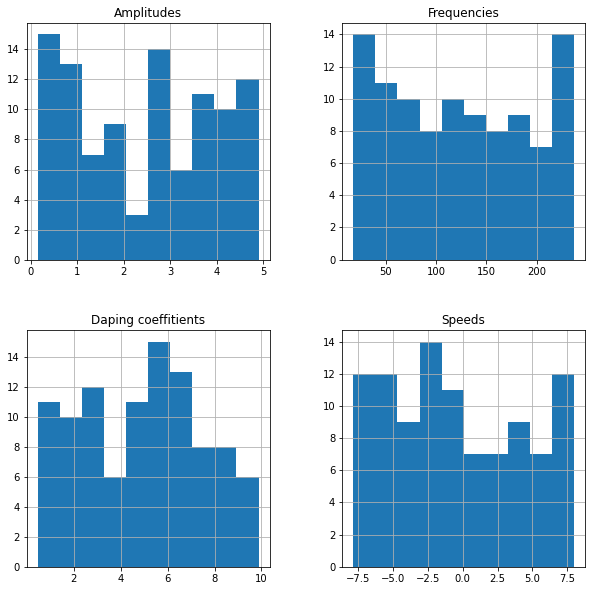

In [9]:
labels.hist(figsize=(10,10))

### Generate data

In [10]:
!git clone https://github.com/DahanDaniel/Algorithm_of_peak_picking.git

fatal: docelowa ścieżka „Algorithm_of_peak_picking” już istnieje i nie jest pustym katalogiem.


In [2]:
import sys
sys.path.insert(0, 'Algorithm_of_peak_picking')

In [3]:
%cd Algorithm_of_peak_picking/
!git pull
%cd ..

/home/anna_s/Ania/UW/projekty/NMR/predict_param_NMR/Algorithm_of_peak_picking
Już aktualne.
/home/anna_s/Ania/UW/projekty/NMR/predict_param_NMR


In [4]:
import copy
from sys import exit
import os

import numpy as np
# from google.colab import files

from Algorithm_of_peak_picking.RadonClass import *

In [69]:
ITERATIONS = 200

NO_SERIES  = 20
RESOLUTION = 2**8 # number of points describing spectra

DWMIN, DWMAX, DDW = -10, 10, .01 # Domain of rates of change

MAX_NO_PEAKS = 1

In [70]:
def create_random_data(max_no_peaks):
    # Draw a random number of peaks between 1 and max_no_peaks.
    N = np.random.randint(1, max_no_peaks+1)

    # Randomize peaks' parameters.
    amplitudes = np.random.uniform(.1, 5, N)
    frequencies = np.random.uniform(10, RESOLUTION - 10, N)
    damping_coeffs = np.random.uniform(0.1, 10, N)
    speeds = np.random.uniform(-8, 8, N)

    # Draw signal-to-noise ratio; set to 0 if no noise should be added.
    snr = np.random.uniform(10, 100) # 0 # 

    params = Params(amplitudes,
                    frequencies,
                    damping_coeffs,
                    speeds,
                    NO_SERIES,
                    RESOLUTION,
                    snr)
    
    radon_instance = Radon(params, DWMIN, DWMAX, DDW, 'Params')

    # Create input dataframe containing radon spectra of the input parameters.
    # Columns represent the frequency dimention,
    # rows represent the Radon (speeds) dimention.
    input_array = radon_instance.complex_Radon.real

    # Create output dataframe.
    output_df = pd.DataFrame({
        'Amplitudes': amplitudes,
        'Frequencies': frequencies,
        'Daping coeffitients': damping_coeffs,
        'Speeds': speeds
    })
    # output_df['SNR'] = snr # not included in fitting

    return input_array, output_df

In [71]:
def generate_dataset():
    X_ds = []
    df_y = pd.DataFrame()
    for i in range(ITERATIONS):
        input_array, output_df = create_random_data(MAX_NO_PEAKS)
        X_ds.append(input_array)
        df_y=df_y.append(pd.DataFrame(output_df))
    X_array = np.array(X_ds)
    return X_array, df_y

In [72]:
data_X, data_y = generate_dataset()

In [73]:
data_X

array([[[ 4.42267194e+00,  4.57144633e+00,  4.46966947e+00, ...,
          4.40743995e+00,  4.34149643e+00,  4.36898768e+00],
        [ 4.40339539e+00,  4.56842842e+00,  4.43688682e+00, ...,
          4.42884061e+00,  4.34328179e+00,  4.35218109e+00],
        [ 4.40291494e+00,  4.57140422e+00,  4.42941895e+00, ...,
          4.44981214e+00,  4.36267615e+00,  4.36507551e+00],
        ...,
        [ 3.09519272e+00,  3.13621437e+00,  3.19118603e+00, ...,
          2.89616550e+00,  3.04465049e+00,  3.20320802e+00],
        [ 3.08594448e+00,  3.11586421e+00,  3.18435838e+00, ...,
          2.94152725e+00,  3.01741376e+00,  3.19893437e+00],
        [ 3.09918290e+00,  3.11723555e+00,  3.17942912e+00, ...,
          3.01682175e+00,  3.03388809e+00,  3.20663201e+00]],

       [[ 2.34669246e+00,  2.52381639e+00,  8.80109540e-01, ...,
          2.01994055e+00,  3.96904190e+00,  2.21805438e+00],
        [ 2.03668928e+00,  2.32928111e+00,  8.05971171e-01, ...,
          1.87847429e+00,  3.33127296e

### Preprocessing data

In [74]:
# normalization data
maxValue = np.amax(data_X)
maxValue

9968.919671656113

In [75]:
data_X /= maxValue

In [76]:
np.amax(data_X)

1.0

In [77]:
data_y

,Amplitudes,Frequencies,Daping coeffitients,Speeds
0,0.323100,204.556780,8.850823,-1.098736
0,3.333680,43.506317,2.257785,0.205683
0,0.904119,50.068788,7.567267,-4.653666
0,3.797014,80.752043,7.452471,5.883374
0,0.146631,176.460934,9.097296,1.356246
...,...,...,...,...
0,0.473301,231.474442,5.206822,6.113158
0,2.161222,123.869427,2.137199,-5.200996
0,0.255517,41.990358,5.301563,-5.493614
0,3.582740,58.488889,1.491188,-3.307837


In [78]:
data_y.shape

(200, 4)

In [79]:
# reshape data
data_X.shape

(200, 2000, 256)

In [80]:
K.image_data_format()

'channels_last'

In [81]:
img_rows, img_cols = 2000, 256

if K.image_data_format() == 'channels_last':
    data_X = data_X.reshape(data_X.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
else:
    data_X = data_X.reshape(X_train.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
    
print(data_X.shape)

(200, 2000, 256, 1)


In [82]:
input_shape = data_X.shape
input_shape

(200, 2000, 256, 1)

In [83]:
X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size=0.3)

### Build the model CNN

In [84]:
def get_triple_cnn():
    return Sequential([
        Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(32, kernel_size=(3, 3), activation='relu'),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25), 

        Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same',),
        Conv2D(64, kernel_size=(3, 3), activation='relu'),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25),

        Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same',),
        Conv2D(128, kernel_size=(3, 3), activation='relu'),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25),

        Flatten(),

        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(4)
    ])

In [85]:
model = get_triple_cnn()
model.compile(loss='mean_squared_error', optimizer='Adam', metrics=['mae'])

### Epochs and Batch Size

In [87]:
epochs = 10
batch_size = 20

### Fit the model

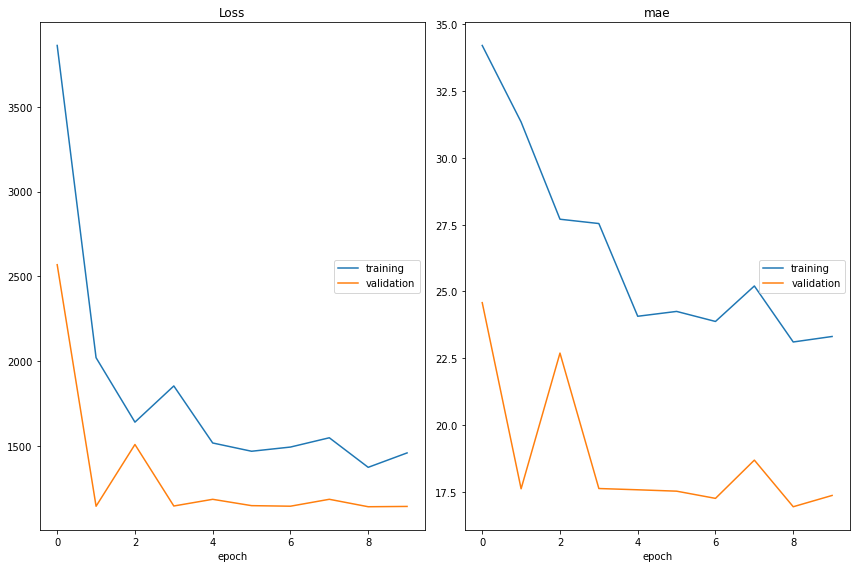

Loss
	training         	 (min: 1375.320, max: 3861.408, cur: 1460.252)
	validation       	 (min: 1143.082, max: 2569.461, cur: 1144.883)
mae
	training         	 (min:   23.109, max:   34.214, cur:   23.315)
	validation       	 (min:   16.939, max:   24.582, cur:   17.361)


In [88]:
%%time
plot_losses = PlotLossesKeras()

history = model.fit(X_train, y_train,
  batch_size=batch_size, epochs=epochs,
  verbose=2,
  callbacks=[plot_losses],
  validation_data=(X_test, y_test))

In [89]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (20, 2000, 256, 32)       320       
_________________________________________________________________
conv2d_7 (Conv2D)            (20, 1998, 254, 32)       9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (20, 999, 127, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (20, 999, 127, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (20, 999, 127, 64)        18496     
_________________________________________________________________
conv2d_9 (Conv2D)            (20, 997, 125, 64)        36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (20, 498, 62, 64)        

### Evaluate model

In [90]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test mae:', score[1])


Test loss: 1144.88330078125
Test mae: 17.361265182495117


In [91]:
def draw_learning_curve(history, key='mae', ylim=(0.8, 1.01)):
    plt.figure(figsize=(12,6))
    plt.plot(history.history[key])
    plt.plot(history.history['val_' + key])
    plt.title('Learning Curve')
    plt.ylabel(key.title())
    plt.xlabel('Epoch')
    plt.ylim(ylim)
    plt.legend(['train', 'test'], loc='best')
    plt.show()

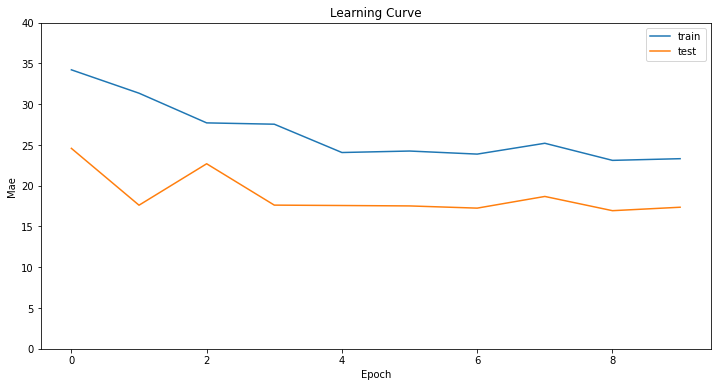

In [96]:
draw_learning_curve(history, 'mae', ylim=(0, 40))

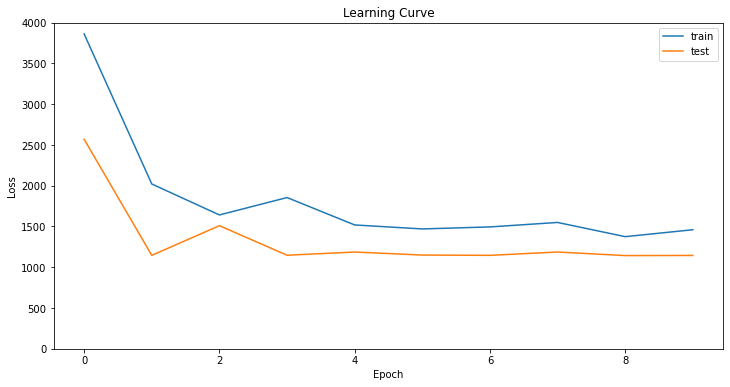

In [101]:
draw_learning_curve(history, 'loss', ylim=(0, 4000))

### Make predictions

In [102]:
y_pred = model.predict(X_test)

In [107]:
# x_ax = range(len(y_test))
# plt.plot(x_ax, y_test.iloc[:,0], label="original")
# plt.plot(x_ax, y_pred[:,0], label="predicted")
# plt.title("Amplitudes test and predicted data")
# plt.legend()
# plt.show()

In [108]:
# x_ax = range(len(y_test))
# plt.plot(x_ax, y_test.iloc[:,1], label="original")
# plt.plot(x_ax, y_pred[:,1], label="predicted")
# plt.title("Frequencies test and predicted data")
# plt.legend()
# plt.show()

In [109]:
# x_ax = range(len(y_test))
# plt.plot(x_ax, y_test.iloc[:,2], label="original")
# plt.plot(x_ax, y_pred[:,2], label="predicted")
# plt.title("Daping_coeffi test and predicted data")
# plt.legend()
# plt.show()

In [110]:
# x_ax = range(len(y_test))
# plt.plot(x_ax, y_test.iloc[:,3], label="original")
# plt.plot(x_ax, y_pred[:,3], label="predicted")
# plt.title("Speeds test and predicted data")
# plt.legend()
# plt.show()